Learn the corrected Jacobi iterator (H) for single-phase problems 
* The iterator is shared by different grids 
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the linear

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from functools import reduce

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [7]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

In [8]:
n = 2**5
grid = SingleGrid(size=2,n=n)

In [9]:
model_name = 'iso_poisson_33x33'
training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_33x33.h5')
model_dir = 'Model/learn_iterator/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

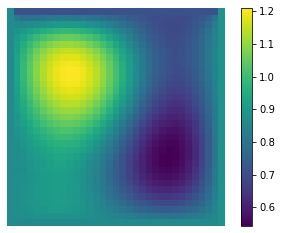

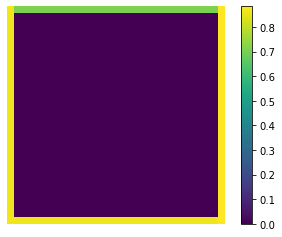

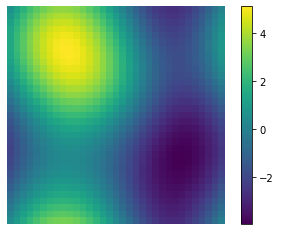

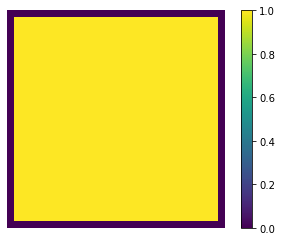

In [10]:
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0], fname='Results/u_train.jpg')
plot.plot_field(bc_value_train[k,0], fname='Results/bc_value_train.jpg')
plot.plot_field(f_train[k,0], fname='Results/f_train.jpg')
plot.plot_field(bc_index_train[k,0], fname='Results/bc_index.jpg')

0 4.20849084854126
1 3.047572374343872
2 2.4332306385040283
3 2.0461628437042236
4 1.7770178318023682
5 1.577547311782837
6 1.422950267791748
7 1.2990913391113281
8 1.19728684425354
9 1.1118903160095215
10 1.0390607118606567
11 0.9760890603065491
12 0.9210065603256226
13 0.8723456859588623
14 0.8289886713027954
15 0.790068507194519
16 0.7549014091491699
17 0.7229403257369995
18 0.6937423944473267
19 0.6669446229934692
20 0.6422467231750488
21 0.6193976402282715
22 0.598186194896698
23 0.5784330368041992
24 0.5599850416183472
25 0.5427103042602539
26 0.5264946818351746
27 0.5112391710281372
28 0.4968568980693817
29 0.48327168822288513
30 0.47041624784469604
31 0.4582310616970062
32 0.44666314125061035
33 0.4356650412082672
34 0.42519456148147583
35 0.4152134656906128
36 0.4056875705718994
37 0.39658573269844055
38 0.3878798484802246
39 0.3795444667339325
40 0.3715561628341675
41 0.36389386653900146
42 0.35653799772262573
43 0.34947070479393005
44 0.34267565608024597
45 0.336137831211090

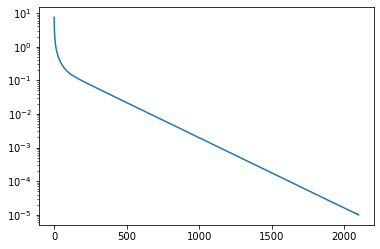

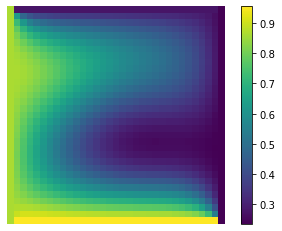

Solution from dataset:


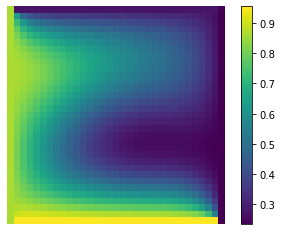

Error (dataset v.s. jacobi):


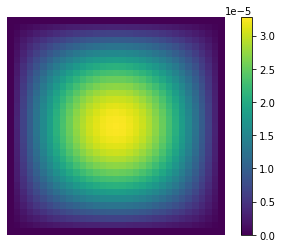

In [6]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [12]:
class HNet(nn.Module):
    def __init__(self, nb_layers):
        super(HNet, self).__init__()

        self.convLayers = nn.ModuleList([nn.Conv2d(1, 1, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, geo_idx):
        '''geo_idx: internal points 1; boundary points 0'''
        return reduce(lambda acc, el: el(acc) * geo_idx, self.convLayers, x)

In [13]:
class HJacIterator(nn.Module):
    def __init__(self, 
                 size=2, 
                 hnet=None,
                 grid=None,
                 n=2**5,
                 batch_size=5,
                 max_epochs=1000,
                 nb_layers=3,
                 model_dir='Model/learn_iterator/iso_poisson'):
        super(HJacIterator, self).__init__()
        self.size = size
        self.n = n
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n)
        else:
            self.grid = grid

        if(hnet is None):
            self.net = HNet(nb_layers)
        else:
            self.net = hnet

        self.optimizer = torch.optim.Adadelta(self.net.parameters())
        self.model_dir=model_dir

    def HRelax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of modified Jacobi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, f)
            u = jac_it + self.net(jac_it-u, self.grid.jac.geometry_idx)
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            u_train, f_train, bc_value_train, bc_index_train = data
        
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            self.grid.ResetBoundary(bc_index_train, bc_value_train)
            ff = self.grid.fnet(f_train)
            uu = self.RandomSampling(f_train)
            
            u_out = self.HRelax(uu, ff, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train


In [8]:
my_iterator = HJacIterator()
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

Step-0 loss: 2468.964080810547
Step-50 loss: 1463.544888305664
Step-100 loss: 1462.7745819091797


KeyboardInterrupt: 

In [11]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))

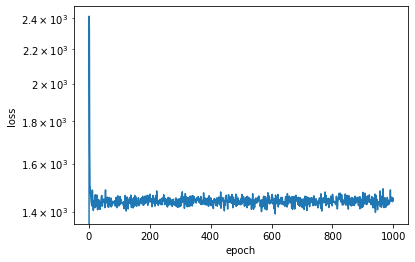

In [22]:
# import the learned model and loss train
my_hnet = HNet(nb_layers=3)
my_hnet.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = HJacIterator(hnet=my_hnet, grid=grid)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('Results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 7.511035919189453
1 2.291078567504883
2 0.8731619119644165
3 0.492287814617157
4 0.3592243194580078
5 0.2907739579677582
6 0.24654249846935272
7 0.21519915759563446
8 0.19193965196609497
9 0.17406129837036133
10 0.1598484069108963
11 0.14817075431346893
12 0.138278067111969
13 0.12967181205749512
14 0.1220201849937439
15 0.115101158618927
16 0.10876406729221344
17 0.10290513932704926
18 0.09745099395513535
19 0.09234853833913803
20 0.08755780756473541
21 0.08304804563522339
22 0.07879439741373062
23 0.07477647066116333
24 0.07097708433866501
25 0.06738124042749405
26 0.06397578120231628
27 0.06074879691004753
28 0.057689737528562546
29 0.05478877201676369
30 0.05203694850206375
31 0.04942600056529045
32 0.04694817587733269
33 0.04459630697965622
34 0.04236353933811188
35 0.04024394601583481
36 0.03823108598589897
37 0.03631976619362831
38 0.03450469300150871
39 0.032780781388282776
40 0.031143369153141975
41 0.02958814613521099
42 0.02811083197593689
43 0.02670757845044136
44 0.02537

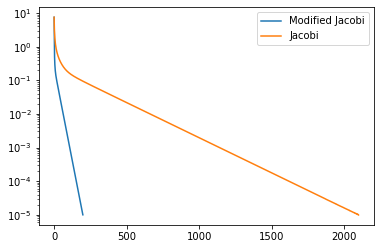

New solution:


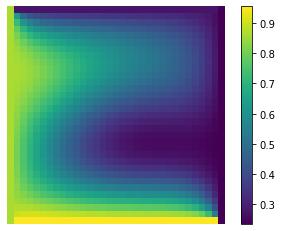

Solution from dataset:


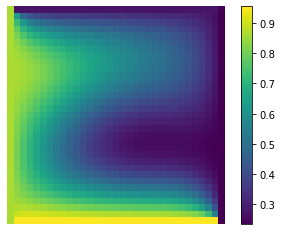

Error (dataset v.s. jacobi):


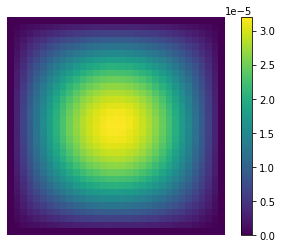

In [13]:
EPS = 1e-5
n_jac_new = 0
u_new = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_new = grid.jac.reset_boundary(u_new)
residual = f_test-grid.Knet(u_new)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_new = [res]
print(n_jac_new, res)
while (abs(res) > EPS):
    n_jac_new += 1
    u_new = new_iterator.HRelax(u_new, f_test, 1)
    residual = f_test-grid.Knet(u_new)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_new.append(res)
    print(n_jac_new, res)

print("Solution converges after", n_jac_new, "modified Jacobi iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

print("New solution:")
plot.plot_field(u_new.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_new.detach().reshape((1,1,n+1,n+1)))

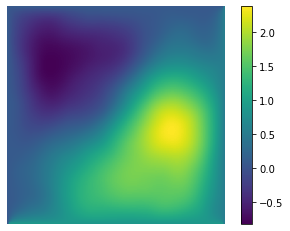

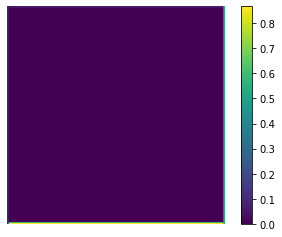

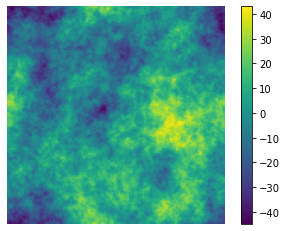

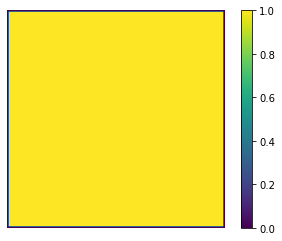

In [24]:
# test on larger grid
test_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_129x129.h5')
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
u_test, f_test, bc_value_test, bc_index_test = next(iter(test_dataloader))

kk=0
plot.plot_field(u_test[kk,0])
plot.plot_field(bc_value_test[kk,0])
plot.plot_field(f_test[kk,0])
plot.plot_field(bc_index_test[kk,0])

In [25]:
n = 2**7
grid_test = SingleGrid(size=2,n=n)

EPS = 5e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid_test.fnet(f_test[kk,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid_test.ResetBoundary(bc_index_test[kk,0].reshape((1,1,n+1,n+1)), bc_value_test[kk,0].reshape((1,1,n+1,n+1)))
u_test = grid_test.jac.reset_boundary(u_test)
residual = f_test-grid_test.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_test = [res]
print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid_test.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid_test.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_test.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")

0 11.552556037902832
0 6.4573469161987305
1 4.678605556488037
2 3.739846706390381
3 3.150202751159668
4 2.7416813373565674
5 2.440154552459717
6 2.207512378692627
7 2.0220296382904053
8 1.8703596591949463
9 1.7438217401504517
10 1.6365106105804443
11 1.544260859489441
12 1.464045524597168
13 1.3936079740524292
14 1.331229567527771
15 1.275577425956726
16 1.2256007194519043
17 1.1804587841033936
18 1.139471411705017
19 1.1020811796188354
20 1.0678274631500244
21 1.0363253355026245
22 1.007251501083374
23 0.9803311824798584
24 0.9553301930427551
25 0.932047426700592
26 0.9103087782859802
27 0.8899633884429932
28 0.8708792924880981
29 0.85294109582901
30 0.8360466361045837
31 0.8201060891151428
32 0.8050394058227539
33 0.7907753586769104
34 0.7772504687309265
35 0.7644075155258179
36 0.7521952986717224
37 0.7405675649642944
38 0.7294822335243225
39 0.7189016938209534
40 0.7087913155555725
41 0.6991197466850281
42 0.6898584961891174
43 0.6809811592102051
44 0.6724637746810913
45 0.66428446

0 11.56417465209961
1 2.3811070919036865
2 1.0241199731826782
3 0.7257476449012756
4 0.5878896117210388
5 0.5003854036331177
6 0.43824416399002075
7 0.39142581820487976
8 0.3547115921974182
9 0.32504990696907043
10 0.30052369832992554
11 0.27986207604408264
12 0.2621888816356659
13 0.24687717854976654
14 0.23346658051013947
15 0.22161127626895905
16 0.21104618906974792
17 0.20156347751617432
18 0.19299912452697754
19 0.18522056937217712
20 0.17812058329582214
21 0.17161060869693756
22 0.16561727225780487
23 0.1600790172815323
24 0.15494386851787567
25 0.1501677930355072
26 0.14571276307106018
27 0.14154624938964844
28 0.13763999938964844
29 0.13396944105625153
30 0.13051296770572662
31 0.12725159525871277
32 0.12416870146989822
33 0.12124931067228317
34 0.11848033964633942
35 0.11584990471601486
36 0.11334754526615143
37 0.11096362769603729
38 0.10868967324495316
39 0.10651793330907822
40 0.10444130003452301
41 0.10245358943939209
42 0.10054880380630493
43 0.09872172027826309
44 0.0969

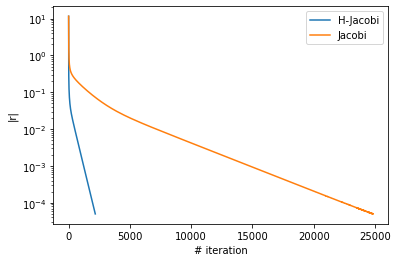

In [29]:
test_iterator = HJacIterator(hnet=my_hnet, grid=grid_test)

EPS = 5e-5
n_jac_test = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid_test.fnet(f_test[kk,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid_test.ResetBoundary(bc_index_test[kk,0].reshape((1,1,n+1,n+1)), bc_value_test[kk,0].reshape((1,1,n+1,n+1)))
u_test = grid_test.jac.reset_boundary(u_test)
residual = f_test-grid_test.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_testnew = [res]
print(n_jac_test, res)
while (abs(res) > EPS):
    n_jac_test += 1
    u_test = test_iterator.HRelax(u_test, f_test, 1)
    residual = f_test-grid_test.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_testnew.append(res)
    print(n_jac_test, res)

print("Solution converges after", n_jac_test, "modified Jacobi iterations ")
plt.plot(res_arr_testnew, label='H-Jacobi')
plt.plot(res_arr_test, label='Jacobi')
plt.yscale('log')
plt.ylabel('|r|')
plt.xlabel('# iteration')
plt.legend()
#plt.show()
plt.savefig('Results/H_jacobi_convergence.jpg', dpi=500, bbox_inches='tight')

In [38]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

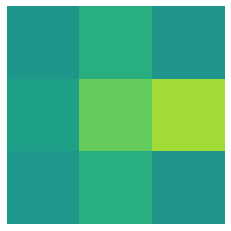

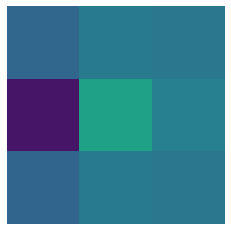

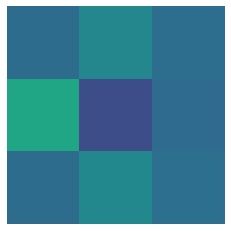

In [39]:
# plot the kernels
mlist = list(my_hnet.parameters())
heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='Results/kernel1.jpg', cbar=False)
heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='Results/kernel2.jpg', cbar=False)
heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='Results/kernel3.jpg', cbar=False)

In [40]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [41]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

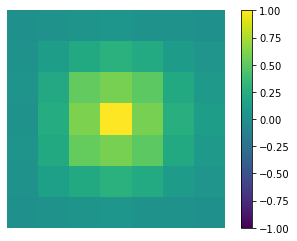

In [42]:
# combined kernel
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='Results/kernel_comb.jpg')

In [88]:
a = torch.randint(0,10,size=(7,7)).float().reshape(1,1,7,7)
a

tensor([[[[7., 1., 8., 2., 2., 0., 8.],
          [0., 3., 2., 3., 3., 3., 3.],
          [2., 4., 7., 5., 1., 9., 7.],
          [8., 3., 5., 9., 7., 0., 8.],
          [1., 4., 6., 6., 5., 1., 5.],
          [6., 2., 3., 5., 1., 7., 2.],
          [8., 6., 4., 5., 6., 2., 9.]]]])

In [89]:
F.conv2d(a, kernel2)

tensor([[[[46.8998]]]])

In [90]:
temp = F.conv2d(a, mlist[0], padding=0)
temp = F.conv2d(temp, mlist[1], padding=0)
F.conv2d(temp, mlist[2], padding=0)

tensor([[[[46.8998]]]], grad_fn=<ConvolutionBackward0>)